In [1]:
import numpy
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.colors # for truncate_colormap
%matplotlib inline

In [2]:
# These are the horizontal grid (ocean_static) files for the OMIP runs
P25grid = netCDF4.Dataset('/archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_static_masked_area.nc')
#for v in P25grid.variables: print(v, end=' ')
P5grid = netCDF4.Dataset('/archive/gold/datasets/OM4_05/mosaic_ocean.v20180227.unpacked/ocean_static_masked_area.nc')
#for v in P5grid.variables: print(v, end=' ')

In [3]:
# These are the z*-coordinate time-averaged output for 1988-2007 for the OMIP runs
P25zdata = netCDF4.Dataset('/archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/'+
                           'OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/pp/'+
                           'ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc')
#for v in P25zdata.variables: print(v, end=' ')
#print('\n',P25zdata.variables['vmo'].shape)
P5zdata = netCDF4.Dataset('/archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/'+
                          'OM4p5_IAF_BLING_CFC_abio_csf_mle200/gfdl.ncrc4-intel16-prod/pp/'+
                          'ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc')
#for v in P5zdata.variables: print(v, end=' ')
#print('\n',P5zdata.variables['vmo'].shape)
P5Nzdata = netCDF4.Dataset('/archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/'+
                           'OM4p5_IAF_BLING_CFC_abio_csf_p25config/gfdl.ncrc4-intel16-prod/pp/'+
                           'ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc')
#for v in P5Nzdata.variables: print(v, end=' ')
#print('\n',P5Nzdata.variables['vmo'].shape)

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """Usage:
      cm=truncate_colormap(cmocean.cm.thermal, minval=0.1)"""
    return matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(numpy.linspace(minval, maxval, n)))

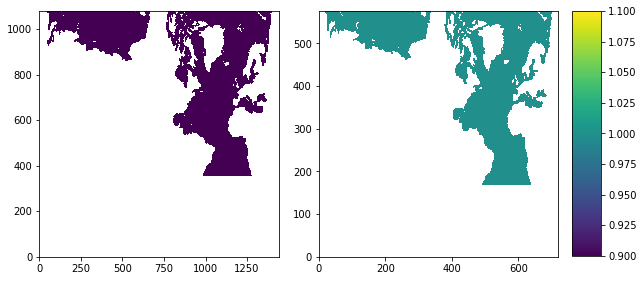

In [5]:
# Check masks for Atlantic + Arctic
plt.figure(figsize=(8,4))
plt.subplot(121);
basin = P25grid.variables['basin'][:]
atl_mask = numpy.zeros(basin.shape)
atl_mask[(basin==2) | (basin==4) | (basin==6) | (basin==7) | (basin==8) | (basin==9) ] = 1
atl_vmask = 1*atl_mask; atl_vmask[:-1,:] = atl_vmask[:-1,:] * atl_vmask[1:,:]
P25atl_vmask = numpy.ma.array( atl_vmask, mask=atl_vmask==0)
plt.pcolormesh(P25atl_vmask); #plt.colorbar();
plt.subplot(122);
basin = P5grid.variables['basin'][:]
atl_mask = numpy.zeros(basin.shape)
atl_mask[(basin==2) | (basin==4) | (basin==6) | (basin==7) | (basin==8) | (basin==9) ] = 1
atl_vmask = 1*atl_mask; atl_vmask[:-1,:] = atl_vmask[:-1,:] * atl_vmask[1:,:]
P5atl_vmask = numpy.ma.array( atl_vmask, mask=atl_vmask==0)
im = plt.pcolormesh(P5atl_vmask); #plt.colorbar();

# Plot colorbar in it's own axes
plt.tight_layout()
cbar_ax = plt.gcf().add_axes([1.0, 0.1, 0.05, 0.85])
plt.gcf().colorbar(im, cax=cbar_ax);

In [6]:
def meridional_transport(nc, mask=None):
    """Zonal sum of vmo from file nc"""
    vmo = nc.variables['vmo'][:]
    if mask is not None:
        vmo = vmo * mask # Mask
    return vmo.sum(axis=-1).mean(axis=0) # sum the i-direction, average the time axis
def psi_from_zavmo(zavmo, top_to_bottom=False):
    """Stream function corresponding to zonally integrated mass transport"""
    shp = zavmo.shape
    psi = numpy.zeros((shp[0]+1,shp[1]))
    if top_to_bottom:
        for k in range(shp[0]):
            psi[k] = psi[k-1] + zavmo[k-1]
    else:
        for k in range(shp[0],0,-1):
            psi[k-1] = psi[k] - zavmo[k-1]
    if type(zavmo) is numpy.ma.core.MaskedArray:
        psi = numpy.ma.array(psi) # Turn into masked array
        psi.mask = zavmo.mask[0,:] # Use broadcasting from 1d to 2d array
    return psi
def zi_for_zcoords(z_i, depth):
    """Returns 3d z* positions for interfaces in the z*-coordinate output using depth and nominal z_i"""
    nk = z_i.shape[0]-1 # Number of h layers
    shp = depth.shape
    zi = numpy.ma.zeros((nk+1,shp[0],shp[1]))
    zi[nk] = -numpy.abs(depth[:,:])
    for k in range(nk,0,-1):
        zi[k-1] = numpy.maximum( -numpy.abs(z_i[k-1]), zi[k] )
    return zi
def zi_at_v_for_zcoords(z_i, depth):
    """Returns 3d z* positions for interfaces at v-points in the z*-coordinate output using depth and nominal z_i"""
    nk = z_i.shape[0]-1 # Number of h layers
    shp = depth.shape
    depth_at_v = 1. * depth[:] ; depth_at_v[1:] = 0.5 * ( depth_at_v[1:] + depth_at_v[:-1] )
    zi = numpy.ma.zeros((nk+1,shp[0],shp[1]))
    zi[nk] = -numpy.abs(depth_at_v[:,:])
    for k in range(nk,0,-1):
        zi[k-1] = numpy.maximum( -numpy.abs(z_i[k-1]), zi[k] )
    return zi

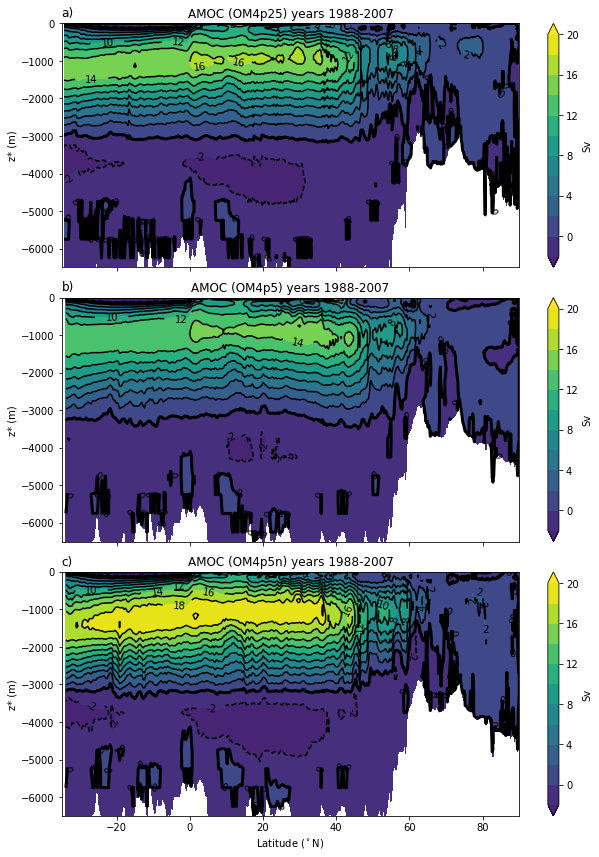

In [7]:
plt.figure(figsize=(9,12))
contour_levels = numpy.arange(-2,22,2)
cm = truncate_colormap(plt.cm.viridis, minval=0.1)

plt.subplot(311)
ni = P25grid.variables['geolat_c'].shape[1]
zi = zi_at_v_for_zcoords(P25zdata.variables['z_i'], P25grid.variables['deptho']).min(axis=-1).filled(0.)
y = P25grid.variables['geolat_c'][:,ni/4-1]
y = y + 0*zi;
psi_p25 = psi_from_zavmo( meridional_transport(P25zdata, mask=P25atl_vmask), top_to_bottom=False )/1.035e9
plt.contourf(y, zi, psi_p25, contour_levels, cmap=cm, extend='both');
cb = plt.colorbar();
cb.set_label('Sv')
CS = plt.contour(y, zi, psi_p25, contour_levels, colors='k');
plt.contour(y, zi, psi_p25, [0], colors='k', linewidths=3);
plt.clabel(CS, inline=1, fontsize=10, fmt='%.0f')
plt.xlim(-35,90)
#plt.xlabel('Latitude $^\circ$N');
plt.ylabel('z* (m)');
plt.title('AMOC (OM4p25) years 1988-2007')
ax=plt.gca()
plt.text(0,1.028,'a)',fontsize=12,transform=plt.gca().transAxes)
plt.gca().set_xticklabels('')

plt.subplot(312)
ni = P5grid.variables['geolat_c'].shape[1]
zi = zi_at_v_for_zcoords(P5zdata.variables['z_i'], P5grid.variables['deptho']).min(axis=-1).filled(0.)
y = P5grid.variables['geolat_c'][:,ni/4-1]
y = y + 0*zi;
psi_p5 = psi_from_zavmo( meridional_transport(P5zdata, mask=P5atl_vmask), top_to_bottom=False )/1.035e9
plt.contourf(y, zi, psi_p5, contour_levels, cmap=cm, extend='both');
cb = plt.colorbar();
cb.set_label('Sv')
CS = plt.contour(y, zi, psi_p5, contour_levels, colors='k');
plt.contour(y, zi, psi_p5, [0], colors='k', linewidths=3);
plt.clabel(CS, inline=1, fontsize=10, fmt='%.0f')
plt.xlim(-35,90)
#plt.xlabel('Latitude $^\circ$N');
plt.ylabel('z* (m)');
plt.title('AMOC (OM4p5) years 1988-2007')
plt.text(0,1.028,'b)',fontsize=12,transform=plt.gca().transAxes)
plt.gca().set_xticklabels('')

plt.subplot(313)
ni = P5grid.variables['geolat_c'].shape[1]
zi = zi_at_v_for_zcoords(P5zdata.variables['z_i'], P5grid.variables['deptho']).min(axis=-1).filled(0.)
y = P5grid.variables['geolat_c'][:,ni/4-1]
y = y + 0*zi;
psi_p5n = psi_from_zavmo( meridional_transport(P5Nzdata, mask=P5atl_vmask), top_to_bottom=False )/1.035e9
plt.contourf(y, zi, psi_p5n, contour_levels, cmap=cm, extend='both');
cb = plt.colorbar();
cb.set_label('Sv')
CS = plt.contour(y, zi, psi_p5n, contour_levels, colors='k');
plt.contour(y, zi, psi_p5n, [0], colors='k', linewidths=3);
plt.clabel(CS, inline=1, fontsize=10, fmt='%.0f')
plt.xlim(-35,90)
plt.xlabel('Latitude ($^\circ$N)');
plt.ylabel('z* (m)');
ti = plt.title('AMOC (OM4p5n) years 1988-2007')
plt.text(0,1.028,'c)',fontsize=12,transform=plt.gca().transAxes)

# Minimize white space
plt.tight_layout()

plt.savefig('atlantic-meridional-overturning.png')